### Описание проекта

Цель — провести анализ и подготовить план действий по удержанию клиентов сети фитнес-центров.

Задачи:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<br>
    1) выделить целевые группы клиентов;<br>
    2) предложить меры по снижению оттока;<br>
    3) определить другие особенности взаимодействия с клиентами.<br>

### План выполнения

- [Загрузка данных и библиотек](#start)
- [Исследовательский анализ данных](#EDA)
- [Модель прогнозирования оттока пользователей ](#regression)
- [Кластеризация пользователей](#cluster)
- [Выводы и рекомендации по работе с клиентами ](#results)

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Здорово, когда есть вступление в сам проект, каждый сможет быстрее разобраться с тем о чем сам проект 👍

</div>

### Шаг №1. Загрузка данных. <a id='start'></a>

In [2]:
# импортируем необходимые модули и библиотеки для дальнейшей работы:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
# откроем таблицу с данными

data = pd.read_csv('gym_churn.csv')
data.head()

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

<b>Набор данных включает следующие поля:</b>

- 'Churn' — факт оттока в текущем месяце

<b>Данные пользователя за предыдущий до проверки факта оттока месяц:</b><br>

- 'gender' — пол<br>
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр<br>
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)<br>
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)<br>
- 'Phone' — наличие контактного телефона<br>
- 'Age' — возраст<br>
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)<br>

<b>Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:</b><br>

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)<br>
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)<br>
- 'Group_visits' — факт посещения групповых занятий<br>
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента<br>
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц<br>
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон<br>

In [4]:
# посмотрим на общую информацию о данных:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В данных 14 столбцов и 4000 строк, пропущенных значений нет. Далее разберём каждую переменную более детально:
<br>
- Переменная gender имеет тип данных int64, где к каждому из полов относится либо 0 либо 1. Предстоит выяснить какой из лэйблов относится к женскому, а какой к мужскому полу. Единичек в данных чуть больше нулей.<br>
<br>
- Проживание или работа в районе, где находится фитнес-центр обозначается единицей, таких случаев основное большинство - 3381.<br>
<br>
- В таких переменных, как 'Partner', 'Promo_friends', 'Phone', 'Group_visits' положительный ответ обозначается цифрой 1, отрицательный - 0.<br>
<br>
- В фитнес-центре имеется 3 типа абонементов: на 1 месяц, на полгода и на год. Большинство посетителей предпочитает составлять краткосрочный контракт на один месяц.<br>
<br>
- Возраст посетителей варьируется от 18 до 41 года. Средний возраст 29 лет. <br>
<br>
- Cуммарная выручка от второстепенных услуг фитнес-центра записана в формате float64. Средний показатель равен 146.94 условным единицам. Максимальная выручка - 552.5, минимальная 0.14<br>
<br>
- Переменная, хранящая срок до окончания текущего действующего абонемента (в месяцах) имеет формат float64, что не совсем логично, так как расчёт ведется в целых месяцах. Тип данных следует поменять на int.<br>
<br>
- Перемення 'Lifetime' хранит время с момента первого обращения в фитнес-центр (в месяцах). Большинство значений сосредоточены в диапазоне от 0 до 9 месяцев. Посетителей, которые обратились в фитнес-центр более 2-ух лет назад - единицы. <br>
<br>
- Cредняя частота посещений в неделю за все время с начала действия абонемента для всей выборки равна 1.8. Максимальное среднее количество посещений равно 6, минимальное 0 - это значит, что есть пропуски за счёт тех, кто совсем не хотил в центр имея абонент<br>
<br>
- Cредняя частота посещений в неделю за предыдущий месяц равна 1.7.<br>
<br>
- Переменная churn принимает значение 1, если факт оттока для посетителя зафиксирован в текущем месяцею И ноль, если нет.

In [5]:
# поменяем тип данных, в столбце "Month_to_end_contract":

data['Month_to_end_contract'] = data['Month_to_end_contract']

In [6]:
# и для дальнейшего удобства переведем названия стобцов к нижнему регистру:

data.columns = data.columns.str.lower()

### Шаг №2. Исследовательский анализ данных (EDA) <a id='EDA'></a>

In [8]:
# взглянем на статистические показатели переменных в таблице:

data.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Статистические показатели таких переменных как gender, Near_Location, Partner, Promo-friends, Phone, Group_visits, Churn не акутальны, потому что по своей сути это категориальные переменные, а не количественные.

Можно предположить, что те посетители, которые имеют среднее количество посещений равное нулю с момента приобретения абонемента, приобрели его совсем недавно. Либо решили не ходить вовсе после приобретения - но это скорее исключение из правил. Поэтому среди таких посетителей не должно быть большого количества уходящих.

In [9]:
# проверим так ли это:

data[data['avg_class_frequency_total']==0]['churn'].sum()

20

Из 88 клиентов с средним количеством посещений в неделю равным нулю, тех кто уходит из фитнес-центра 20. А вот среднее количество посещений в неделю за последний месяц - более показательная оценка намерений. Так как большинство клиентов центра не занимавшихся ни разу за месяц решили уйти из данного фитнес-центра. 

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался более детально.

In [10]:
# сгруппируем данные по значениям churn и выведем средние значения для двух групп:

data.groupby('churn').agg({'age':'mean','avg_additional_charges_total':'mean','month_to_end_contract':'mean',\
                           'lifetime':'mean','avg_class_frequency_total':'mean','avg_class_frequency_current_month':'mean'})


age  avg_additional_charges_total  month_to_end_contract  \
churn                                                                   
0      29.976523                    158.445715               5.283089   
1      26.989632                    115.082899               1.662582   

       lifetime  avg_class_frequency_total  avg_class_frequency_current_month  
churn                                                                          
0      4.711807                   2.024876                           2.027882  
1      0.990575                   1.474995                           1.044546

В группах уходящих и остающихся есть различия. Выделим основные наблюдения:

- средний возраст уходящих меньше
- в группе оттока средняя суммарная выручка от других услуг фитнес-центра, таких как кафе, спорт-товары, косметический и массажный салон меньше - 115 условных единиц к 158 в группе остающихся посетителей
- Среднее количество месяцев до окончания срока абонементов 5 месяцев в группе пользователей остающихся, и 1 месяц у тех, кто уходит
- Также интересно, что у группы оттока среднее количество месяц со дня обращения в фитнес-центр 0,9 в то время как у остающихся показатель 4.7. Это говорит о том, что в большинстве случаев решение об уходе из фитнес-центра принимается в начале пользовательского опыта. 
- Группа оттока имеет более низкие показатели среднего посещения в неделю за весь период 1.4 к 2
- Показатель смреднего посещения понизился ещё больше к последнему месяцу, когда и было принято решение уходить


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [11]:
# Построим график распределения возрастных значений в двух группах:

plt.figure(figsize=(10,8))
fig = px.histogram(data,x='age',color='churn')
fig.update_layout(title_text='График распределения возрастных значений в двух группах')
fig.update_xaxes(title='Возраст')
fig.update_yaxes(title='Количество клиентов')
fig.show()

<Figure size 720x576 with 0 Axes>

В группе оттока возраст клиентов варьируется от 18 до 38. Но основная часть значений в диапазоне от 24 до 29. Возможно это связано с тем, что часть в группе оттока начала ходить в фитнес-центр не так давно, а значит спорт не является частью их образа жизни. Поэтому уход может быть связан не с самим фитнес-центром, а с личными привычками посетителей. 

In [12]:
# показатели средней суммарной выручки в двух группах:

plt.figure(figsize=(10,8))
fig = px.histogram(data,x='avg_additional_charges_total',color='churn')
fig.update_layout(title_text='Распределение средней суммарной выручки в группах')
fig.update_xaxes(title='Средняя суммарная выручка с дополнительных услуг')
fig.update_yaxes(title='Количество клиентов')
fig.show()

<Figure size 720x576 with 0 Axes>

В целом, в обоих группах одинаковая тенденция. Основная выручка с дополнительных услуг центра варьируется в диапазоне до 250 условных единиц.

In [13]:
# график по количеству месяцев до окончания срока абонемента:

plt.figure(figsize=(10,8))
fig = px.histogram(data,x='month_to_end_contract',color='churn')
fig.update_layout(title_text='Распределение абонементов по количеству месяцев до окончания срока действия в двух группах')
fig.update_xaxes(title='Количество месяцев до окончания контракта')
fig.update_yaxes(title='Количество абонементов')
fig.show()


<Figure size 720x576 with 0 Axes>

Как мы выяснили ранее, наиболее популярный абонемент - сроком на месяц. Поэтому в обоих группах количество клиентов с контрактом, заканчивающимся через месяц большинство. Но в группе оттока пропорционально таких абонентов больше и совсем мало тех, кто решил уйти имея ещё полгода и более в запасе.

In [14]:
# график среднего посещения центра за весь период:

plt.figure(figsize=(10,8))
fig = px.histogram(data,x='avg_class_frequency_total',color='churn')
fig.update_layout(title_text='Среднее количество посещений фитнес-центра за весь период в двух группах')
fig.update_xaxes(title='Среднее количество посещений')
fig.update_yaxes(title='Количество клиентов')
fig.show()

<Figure size 720x576 with 0 Axes>

Как видим, среднее количество посещений в группе оттока ниже. Максимальный показатель -3.55 посещений в неделю. Всего 15 человек посещали центр в среднем более 3 раз в неделю за весь период. В то время как в группе оставшихся максимальный средний показатель достигает 6 посещений в неделю. Можно сделать вывод, чем активнее посетители, тем дольше они будут оставаться клиентами центра.

In [15]:
# график среднего посещения центра за последний месяц:

plt.figure(figsize=(10,8))
fig = px.histogram(data,x='avg_class_frequency_current_month',color='churn')
fig.update_layout(title_text='Среднее количество посещений фитнес-центра за последний месяц в двух группах')
fig.update_xaxes(title='Среднее количество посещений')
fig.update_yaxes(title='Количество клиентов')
fig.show()

<Figure size 720x576 with 0 Axes>

В группе оттока всего около 10% клиентов посещали центр более двух раз в неделю за последний месяц. Основное большинство приходило в центр только один раз в неделю и менее, то есть почти его не посещала. В группе оставшихся клиентов, показатели выше. Здесь основная часть группы посещала центр более одного раза в неделю. Из этого следует вывод, что если активность посещений идёт на спад - уход из центра близок. 

Теперь построим матрицу корреляций, но прежде выделим количественные признаки в отдельный датафрэйм.

In [16]:
# выделим интересующие признаки в отдельную таблицу:

data_selected_columns = data[['age','avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']]



In [17]:
# построим матрицу корреляций:

data_selected_columns.corr()

age  avg_additional_charges_total  \
age                                1.000000                      0.080240   
avg_additional_charges_total       0.080240                      1.000000   
month_to_end_contract              0.134511                      0.113958   
lifetime                           0.164693                      0.079028   
avg_class_frequency_total          0.119953                      0.044426   
avg_class_frequency_current_month  0.183095                      0.079570   

                                   month_to_end_contract  lifetime  \
age                                             0.134511  0.164693   
avg_additional_charges_total                    0.113958  0.079028   
month_to_end_contract                           1.000000  0.161078   
lifetime                                        0.161078  1.000000   
avg_class_frequency_total                       0.085387  0.112338   
avg_class_frequency_current_month               0.147605  0.181975   

                                   avg_class_frequency_total  \
age                                                 0.119953   
avg_additional_charges_total                        0.044426   
month_to_end_contract                               0.085387   
lifetime                                            0.112338   
avg_class_frequency_total                           1.000000   
avg_class_frequency_current_month                   0.952739   

                                   avg_class_frequency_current_month  
age                                                         0.183095  
avg_additional_charges_total                                0.079570  
month_to_end_contract                                       0.147605  
lifetime                                                    0.181975  
avg_class_frequency_total                                   0.952739  
avg_class_frequency_current_month                           1.000000

Text(0.5, 1.0, 'Матрица корреляций признаков')

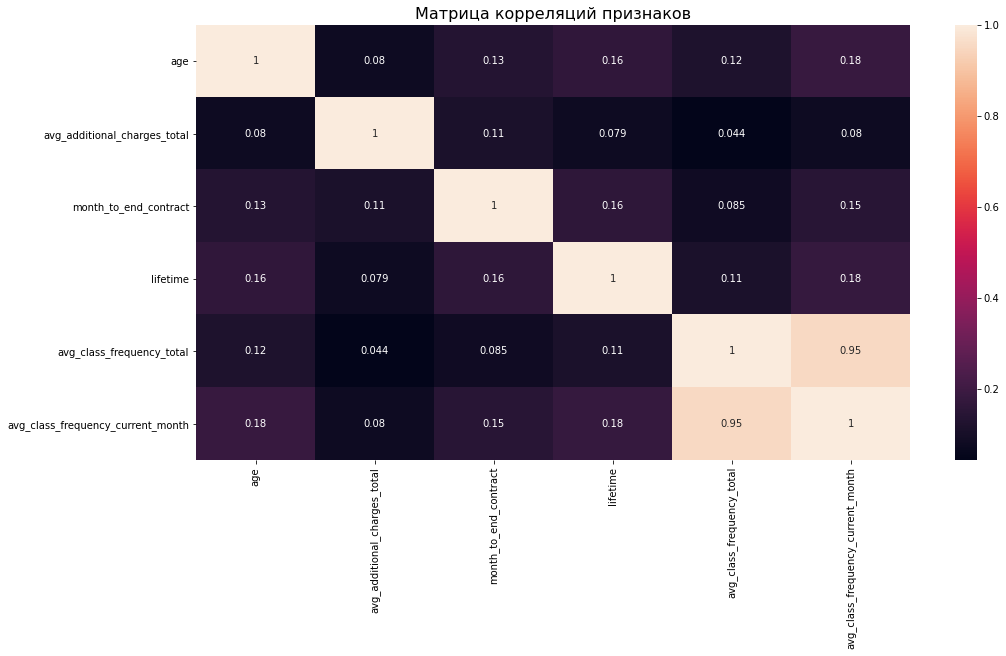

In [18]:
# визуализируем её:

plt.figure(figsize=(16,8))
sns.heatmap(data_selected_columns.corr(),annot=True)
plt.title('Матрица корреляций признаков', size=16)

Переменная 'avg_class_frequency_total' коррелирует с переменной 'avg_class_frequency_current_month'- это логично, так как обе переменные измеряют одно и то же, только за разный отрезок времени. Эту корреляцию стоит учесть при построении регрессионных моделей, и выделить один признак из этих двух.

### Шаг 3. Модель прогнозирования оттока пользователей <a id='regression'> </a>

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. 

In [19]:
# выедлим целевую переменную и признаки, сохраним их отдельно, в признаках уберём переменную 'avg_class_frequency_total':

X = data.drop(['churn','avg_class_frequency_total'],axis=1)
y = data['churn']

In [20]:
# разобъем данные на обучающую и валидационную выборку:

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=0)

In [21]:
# стандартизируем наши данные:

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом, а затем оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Это позволит нам сравнить две модели и понять какая из них показала себя лучше, основываясь на метриках.

In [22]:
# зададим список моделей:

models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

# создадим функцию:

def make_predictions(m, X_train_st, y_train, X_test_st, y_test):
    model = m
    model.fit(X_train_st,y_train)
    prediction = model.predict(X_test_st)
    print('Accuracy:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(accuracy_score(y_test, prediction),\
                                                                    precision_score(y_test, prediction),\
                                                                   recall_score(y_test, prediction)))



In [23]:
# вызовем функцию в цикле для каждой модели:

for model in models:
    print(model)
    make_predictions(m=model,X_train_st=X_train_st, y_train=y_train, X_test_st=X_test_st, y_test=y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:0.90, Precision:0.79, Recall:0.83
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy:0.89, Precision:0.81, Recall:0.75


Метрика Accuracy указывает на долю правильных ответов алгоритма, показатели этой метрики почти равны для двух моделей. Но учитывая, что классы не равные - в выборке оставшихся клиентов почти в три раза больше, метрика accuracy не особо показательна. Сравним две другие метрики. Метрика recall демонстрирует способность алгоритма обнаруживать данный класс вообще. Показатель выше для модели логистической регрессии. Показатель 'Precision' выше для модели с алгоритмом случайного леса, это значит для данного класификатора степень доверия выше .Так как данная метрика хороший показатель несбалансированных выборок, будем придерживаться её показателя. Но сказать, что модель случайного леса показала себя лучше чем логистическая регрессия с уверенностью нельзя. Для того, чтобы убедиться в верности наших предположений высчитаем метрику F1 для каждой модели и сделаем финальное заключение.

In [24]:
# подсчёт метрики f1:

F1_logistic = 2 * (0.79 * 0.83) / (0.79 + 0.83)
F1_random_forest = 2 * (0.81 * 0.75) / (0.81 + 0.75)
print('Метрика F1 для модели логистической регрессии:', F1_logistic,'\nМетрика F1 для модели случайного леса:',F1_random_forest)

Метрика F1 для модели логистической регрессии: 0.8095061728395061 
Метрика F1 для модели случайного леса: 0.7788461538461539


Подсчёт метрики F1 позволил сделать заключение, что модель логистической регрессии показала себя лучше.

### Шаг 4. Сделайте кластеризацию пользователей <a id='cluster'> </a>

In [25]:
# сохраним признаки, убрав столбец 'churn' и стандартизируем данные:

X_cluster = data.drop('churn',axis=1)
X_sc = scaler.fit_transform(X_cluster)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

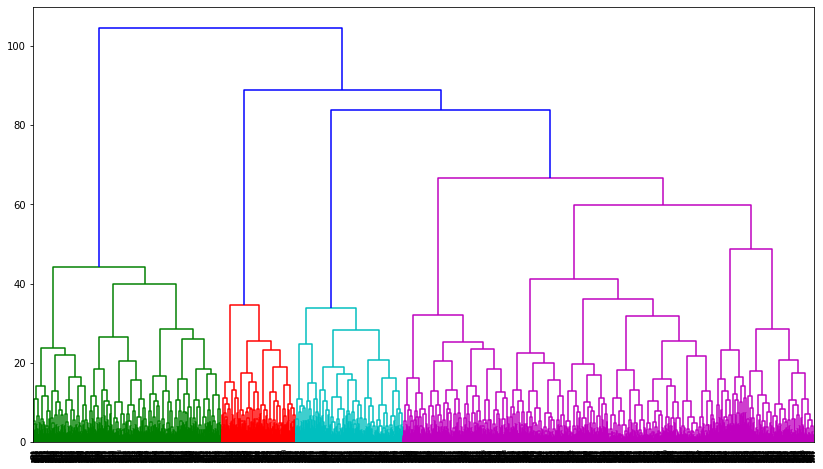

In [26]:
# построим матрицу растояний:

linked = linkage(X_sc, method='ward')

# нарисуем дендрограмму:

plt.figure(figsize=(14,8))
dendrogram(linked,orientation='top')
plt.show()

Согласно дендрограмме, оптимальное число кластеров 4, которые обозначаются на графике разным цветом. Далее обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [27]:
# зададим модель k-means с числом кластеров равным 5:

km = KMeans(n_clusters=5, random_state=0)
labels= km.fit_predict(X_sc)

# сохраним метки кластеров в отдельный столбец датасета:

data['cluster_km'] = labels

In [28]:
# для удобства поменяем названия кластеров:

data.loc[data['cluster_km']==4,'cluster_km']=5
data.loc[data['cluster_km']==3,'cluster_km']=4
data.loc[data['cluster_km']==2,'cluster_km']=3
data.loc[data['cluster_km']==1,'cluster_km']=2
data.loc[data['cluster_km']==0,'cluster_km']=1

In [29]:
# сравним размеры кластеров:

data['cluster_km'].value_counts()

2    1066
5     936
3     832
4     781
1     385
Name: cluster_km, dtype: int64

Самые большие по размеру кластеры - №2 и №5. Самые маленькие - №4 и №1 - они более чем в два раза меньше лидирующих. Кластер номер 3 - средний по количеству человек. 

In [30]:
# посмотрим на средние значения признаков для кластеров:

clusters_mean = data.groupby('cluster_km').mean()
clusters_mean

gender  near_location   partner  promo_friends     phone  \
cluster_km                                                               
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.480300       0.812383  0.000000       0.086304  1.000000   
3           0.560096       0.858173  0.337740       0.197115  0.998798   
4           0.509603       0.750320  1.000000       0.451985  1.000000   
5           0.495726       0.943376  0.752137       0.541667  1.000000   

            contract_period  group_visits        age  \
cluster_km                                             
1                  4.787013      0.425974  29.301299   
2                  1.863039      0.324578  28.136961   
3                  2.734375      0.449519  30.204327   
4                  2.554417      0.303457  28.499360   
5                 11.352564      0.564103  29.993590   

            avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster_km                                                                  
1                             143.957664               4.475325  3.924675   
2                             131.299377               1.787992  2.346154   
3                             164.628354               2.522837  5.007212   
4                             129.812508               2.370038  2.832266   
5                             164.563799              10.376068  4.817308   

            avg_class_frequency_total  avg_class_frequency_current_month  \
cluster_km                                                                 
1                            1.847220                           1.716369   
2                            1.325794                           1.086387   
3                            2.926304                           2.932554   
4                            1.355379                           1.176172   
5                            2.028169                           2.020129   

               churn  
cluster_km            
1           0.267532  
2           0.550657  
3           0.048077  
4           0.395647  
5           0.023504

Средние значения признаков в кластерах позволяют выделить следующие различия:

1. Кластеры под номером 2 и 4 имеют наиболее высокие показатели оттока. Наименьшие показатели в кластерах №5 и №3.
3. Признак 'Partner' указывает на то, что клиент - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента). В группе №5 этот показатель равен 0.75, то есть довольно высокий. В то время как в группе №2 он равен нулю. Можно предположить, что этот фактор является решающим при выборе фитнес-центра и ухода из него для части клиентов.
4. Также, в группе №5 с наименьшим показателем оттока средняя длительность текущего абонемента равна 11.3 месяцам, это может говорить о намерениях клиентов данной группы. Если человек берёт абонемент на длительный срок, то скорее всего он не уйдёт из центра спустя два месяца. Среднее время с первого обращения в центр в группе номер 5 - 4.8 месяца, а среднее количество месяцев до окончания срока абонементов-10.3. Значит эта группа начала посещать фитнес-центр не так давно. В группе номер 2 средняя длительность текущего абонемента равна 1.8 месяца - самый низкий показатель по кластерам. Кроме того среднее количество месяцев до кончания срока абонемента - 1.7 - совсем немного. Так как терять особо нечего, клиенты группы №2 могут с легкостью перестать посещать центр. Можно заключить, что чем продолжительнее срок абонемента, тем дольше человек будет оставаться клиентом фитнес-центра.
5. В группе №3 самые высокие показатели по активности посещения - 2.9 раз в неделю. Это значение актуально как для текущего месяца, так и для всего периода в целом. Наименее активные группы - номер 2 и 4 имеют наиболее высокие показатели оттока. Получается, чем стабильнее и активнее посещение фитнес-центра, тем менее вероятно, что клиент примет решение об уходе в ближайшее время. 
6. Группы №3 и №5 имеют более высокие показатели по тратам на дополнительные услуги и товары фитнес-центра, а также более высокий средний возраст в группе. Для групп №2 и №4 показатели по тратам меньше на 25-30 условных единиц, а по возрасту на 1-2 года. 

Далее построим графики распределения признаков для каждого кластера и проанализируем их.

In [31]:
# Построим распределения признаков для кластеров. Начнём с бинарных переменных, напишем для них функцию:

def show_clusters_on_plot_binary(df, x_name, cluster_name):
    sns.catplot(x=cluster_name,y='churn', hue=x_name,data=df, kind='bar',height=8.27, aspect=11.7/8.27)
    plt.title('Показатель {} для разных кластеров с учётом уровня оттока'.format(x_name))
    plt.xlabel('Кластеры')
    plt.ylabel('Уровень оттока')
    


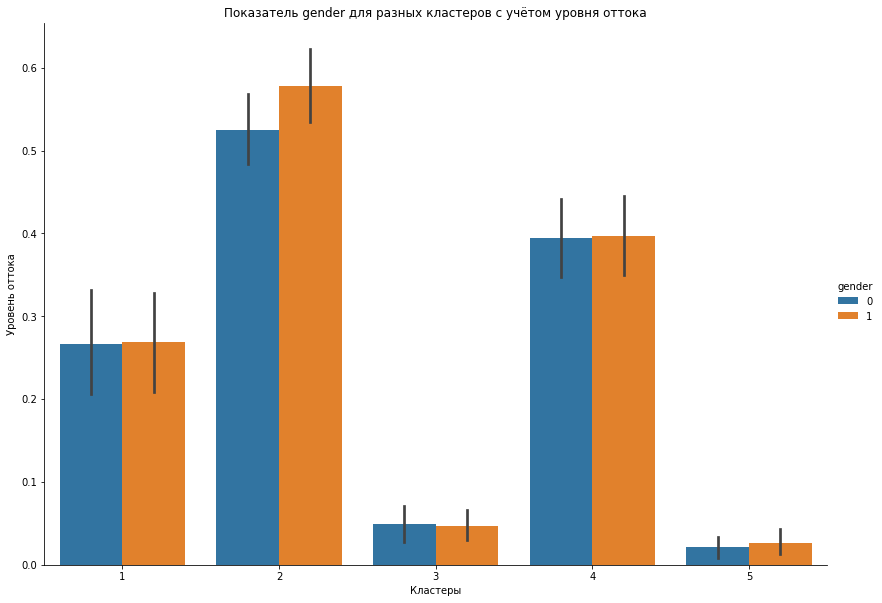

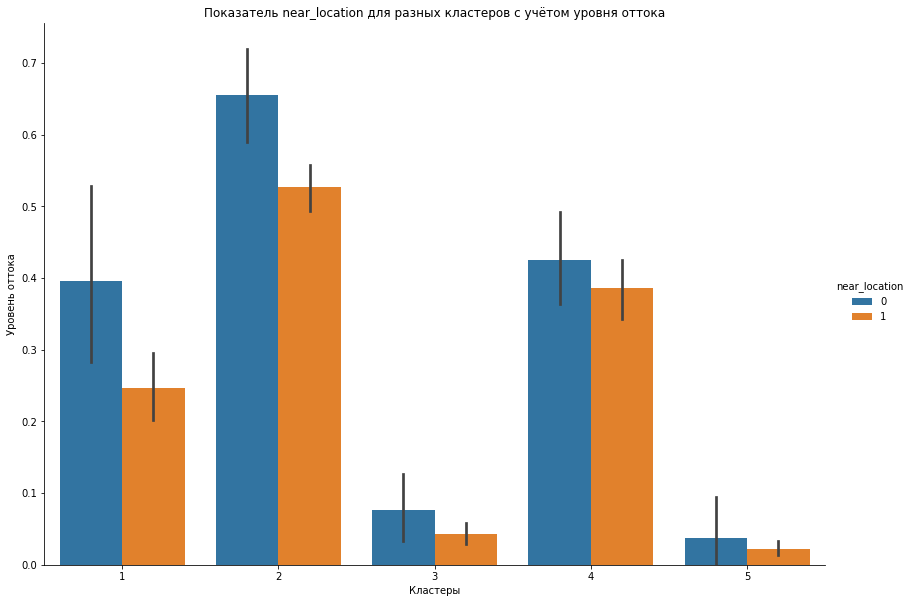

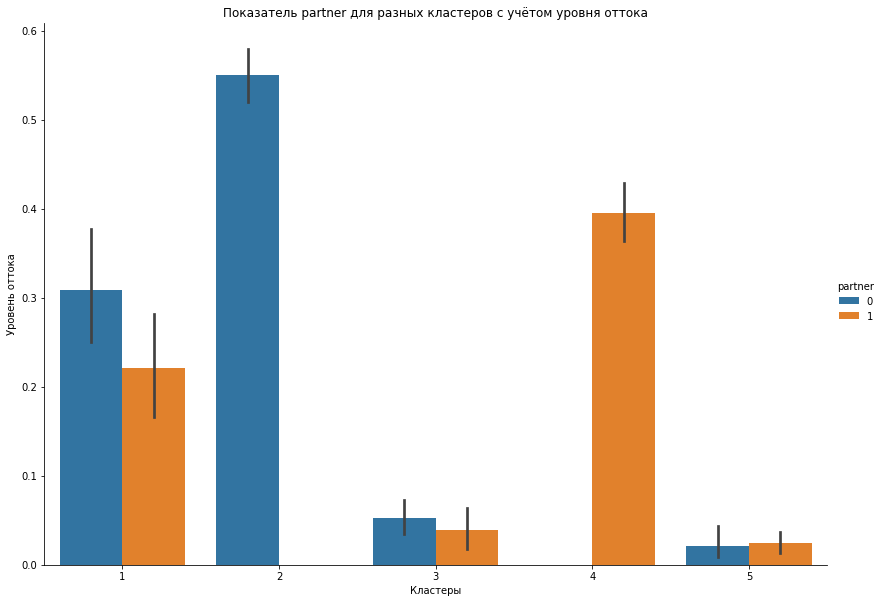

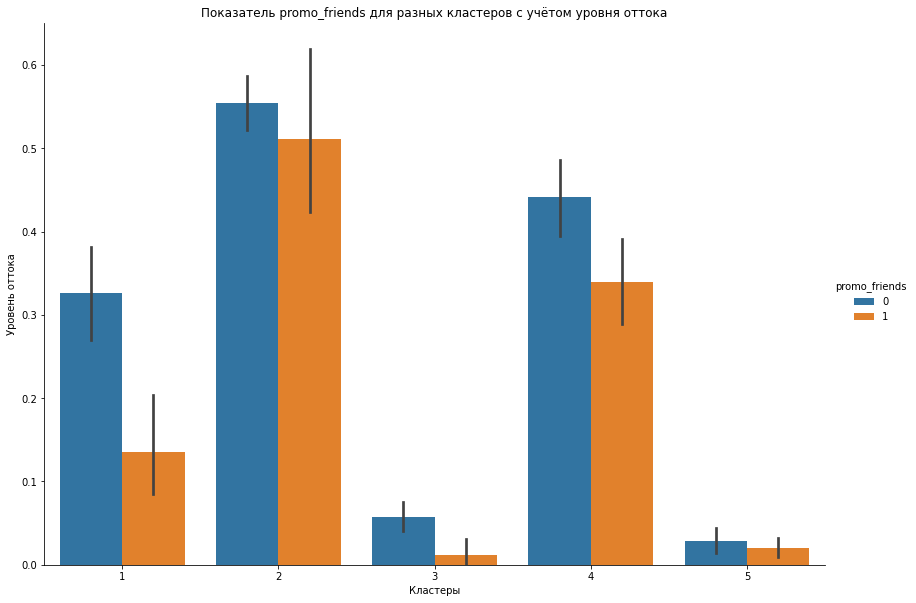

In [32]:
# вызовем функцию построения для всех бинарных переменных:

show_clusters_on_plot_binary(data,'gender','cluster_km')
show_clusters_on_plot_binary(data,'near_location','cluster_km')
show_clusters_on_plot_binary(data,'partner','cluster_km')
show_clusters_on_plot_binary(data,'promo_friends','cluster_km')

Описание графиков:

1. Во всех кластерах наблюдается баланс по гендерному распределению. Гендер, обозначаемый цифрой 1, слегка впереди для большинства кластеров. Наибольшая разница заметна в группе №2 - лидеру по уровню оттока клиентов.
2. Во всех кластерах процент оттока клиентов для кого фитнец-центр располагался близко к дому или работе меньше, чем тех для кого он располагался относительно-далеко. 
3. В группе №2 совсем нет тех, кто является сотрудником компании-партнера фитнес-центра, а значит, весь кластер не имеет доступа к спеуиальным партнерским скидкам и предложениям. А вот в кластре №4 - наоборот. Все клиенты - это сотрудники компаний-партнеров, но несмотря на это показатели оттока в группе высокие.
4. Во всех кластерах есть часть людей, которые записывались в центр и оплачивали услуги по промо-акции "приведи друга". Для всех кластеров уровень оттока в таких кейсов меньше, чем в кейсах без использования промо-акции.

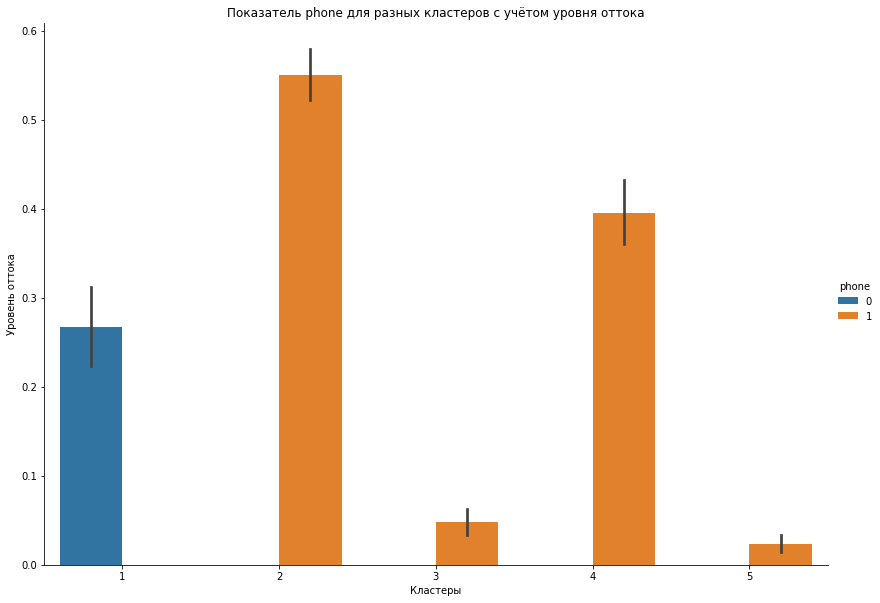

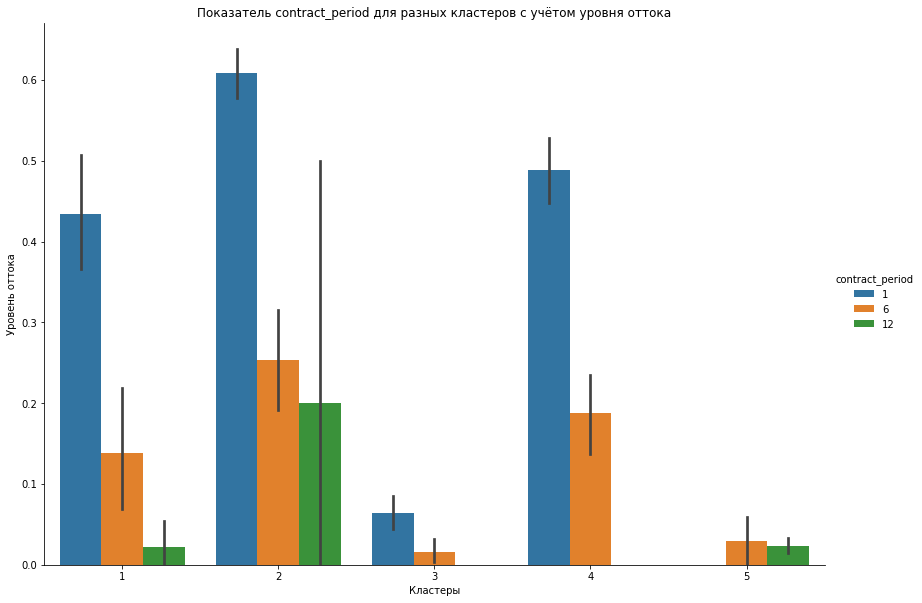

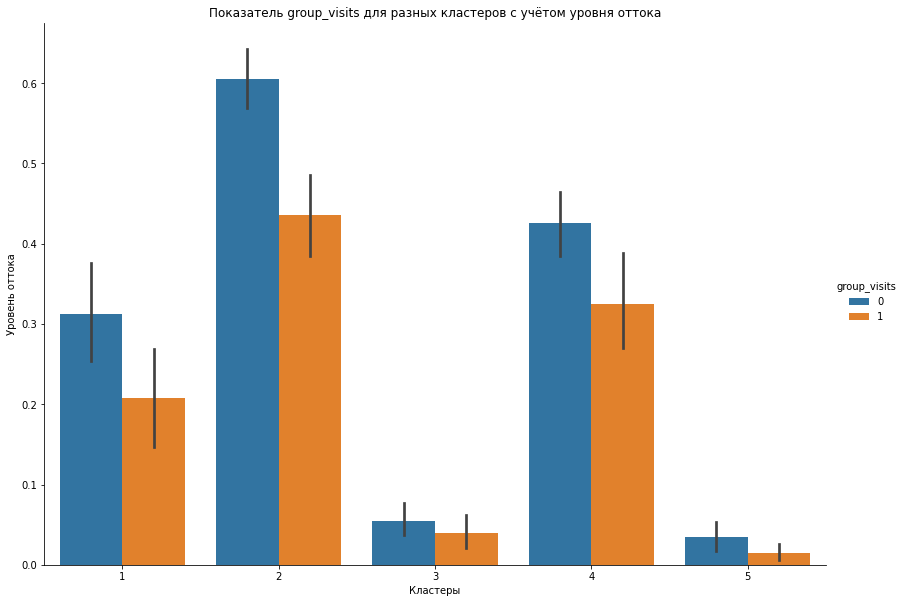

In [33]:
# вызовем функцию построения для всех остальных бинарных переменных:

show_clusters_on_plot_binary(data,'phone','cluster_km')
show_clusters_on_plot_binary(data,'contract_period','cluster_km')
show_clusters_on_plot_binary(data,'group_visits','cluster_km')

Описание графиков:
1. В группе №1 все клиенты не имеют или не указали контактного номера телефона. С учётом низкого уровня оттока в данной группе, можем заключить, что контактный номер не является показателем намерений клиента.
2. В кластере №5 все абоненементы имеют контрактный период от 6 до 12 месяцев. В кластерах №1 и №2 - абонементы от 1 до 12 месяцев. В кластерах №3 и №4 - абонементы от 1-6 месяцев. Наиболее высокие уровни оттока во всех кластерах в абонементах с меньшим сроком действия. А значит, фитнес-центру выгоднее продавать абонементы на срок более чем 1 месяц.
3. Во всех группах, чать людей, которые посещали групповые занятия- имеет меньший уровень оттока, чем те, кто их не посещал.

In [34]:
# построим графики распределения для непрерывных признаков. напишем для этого функцию:

def show_clusters_on_plot_cont(df, x_name, cluster_name):
    plt.figure(figsize=(16,8))
    for cluster in df[cluster_name].unique():
        subplot = df[df[cluster_name]==cluster]
        sns.distplot(subplot[x_name],subplot,kde=True,hist=False,label=cluster)
    plt.title('Показатель {} для разных кластеров'.format(x_name))
    plt.xlabel(x_name)
    plt.ylabel('Уровень плотности')
    plt.legend()


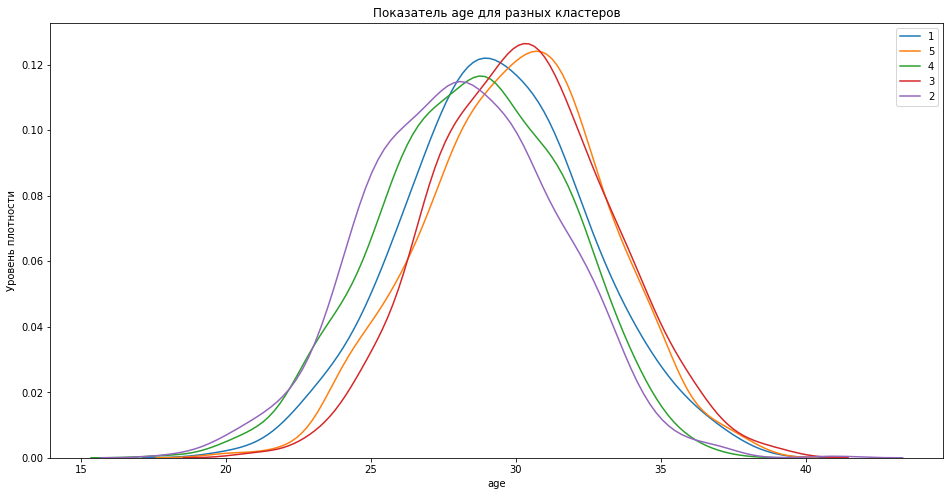

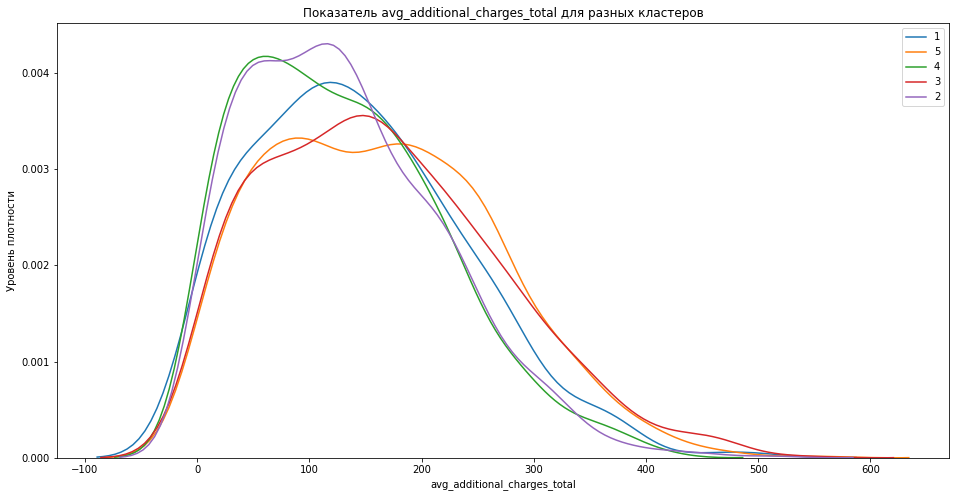

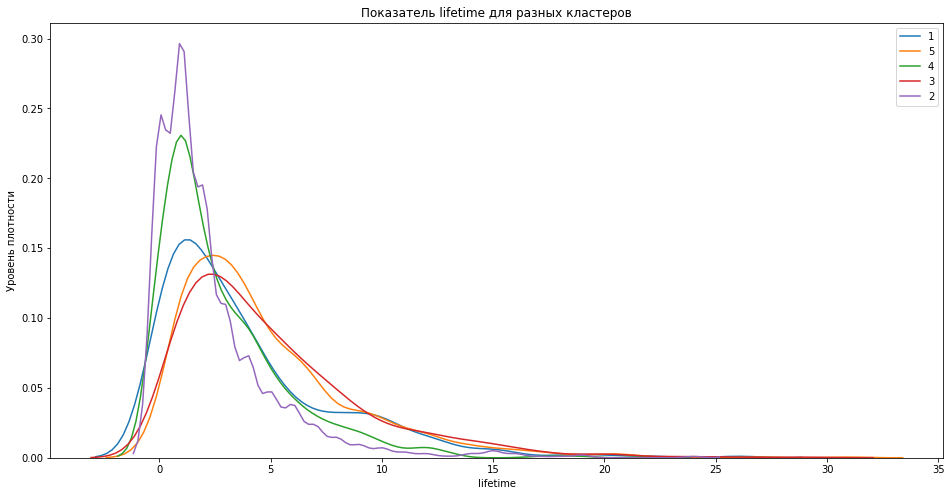

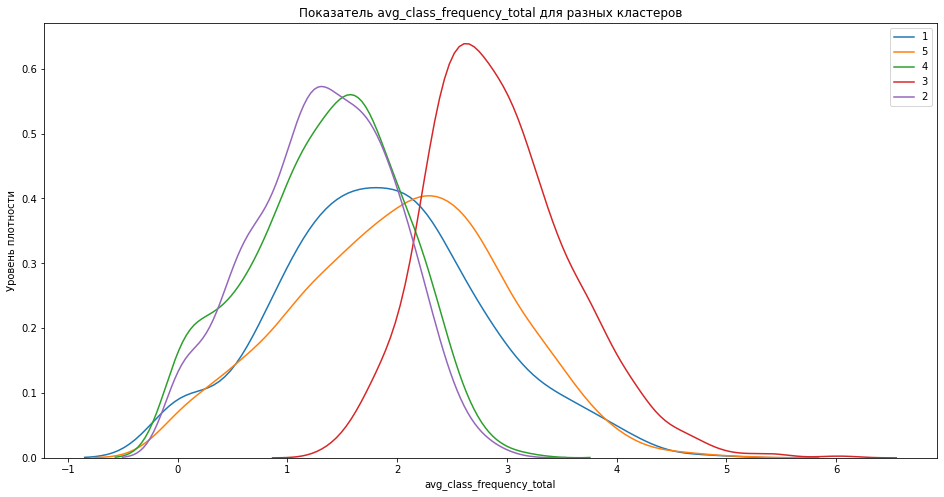

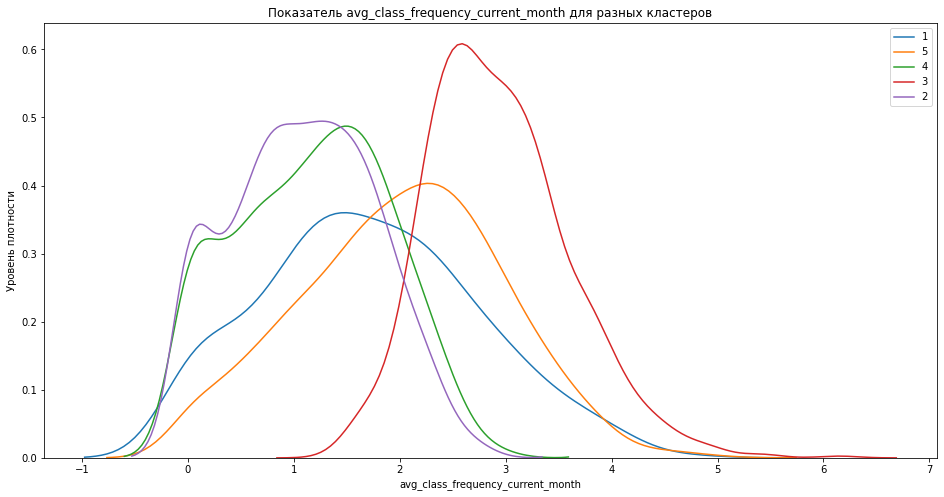

In [35]:
# вызовем функцию для всех непрерывных переменных и интерпретируем графики:

show_clusters_on_plot_cont(data,'age','cluster_km')
show_clusters_on_plot_cont(data,'avg_additional_charges_total','cluster_km')
show_clusters_on_plot_cont(data,'lifetime','cluster_km')
show_clusters_on_plot_cont(data,'avg_class_frequency_total','cluster_km')
show_clusters_on_plot_cont(data,'avg_class_frequency_current_month','cluster_km')

Описание графиков:

1. Кластеры не сильно отличаются по составу возрастных групп, это связано с тем, что основная часть клиентов находится в диапазоне от 25 до 35 лет. В группах №3 и №5 наблюдается небольшой сдвиг вправа, это говорит о том, что в данных кластерах средний возраст клиентов немного выше.
2. Второстепенные траты в фитнес-центре для группы №2 и №4 ниже по плотности в диапазоне более 200 условных единиц. И хотя основная чать значений для всех кластеров находится примерно на одном уровне, в группах №3 и №5 зафиксированы более высокие траты, которые смещают средний показатель в высшую сторону.
3. Меньше всего времени со дня обращения в фитнес-центр прошло для кластров №2 и №4 - это скорее всего связано с абонементиами сроком на один месяц, которые наиболее распространены в данных группах. 
4. Клиенты в группе №3 - наиболее активно посещают фитнес-центр. В группах №1 и №5 - этот показатель средний, а в группах №2 и №4 - низкий - основная чать значений находится на уровне - 1 посещение в неделю.
5. Если рассматривать показатели на текущий месяц, то можно увидеьть, что значения для групп №2 и №4 сместились ещё немного в меньшую сторону. Для других групп показатели остались на прежднем уровне. Можно сделать вывод, что резкий спад активности сигнализирует о высокой вероятности оттока клиента в текущем месяце, и чем активнее и стабльнее посещение - тем вероятность меньше.

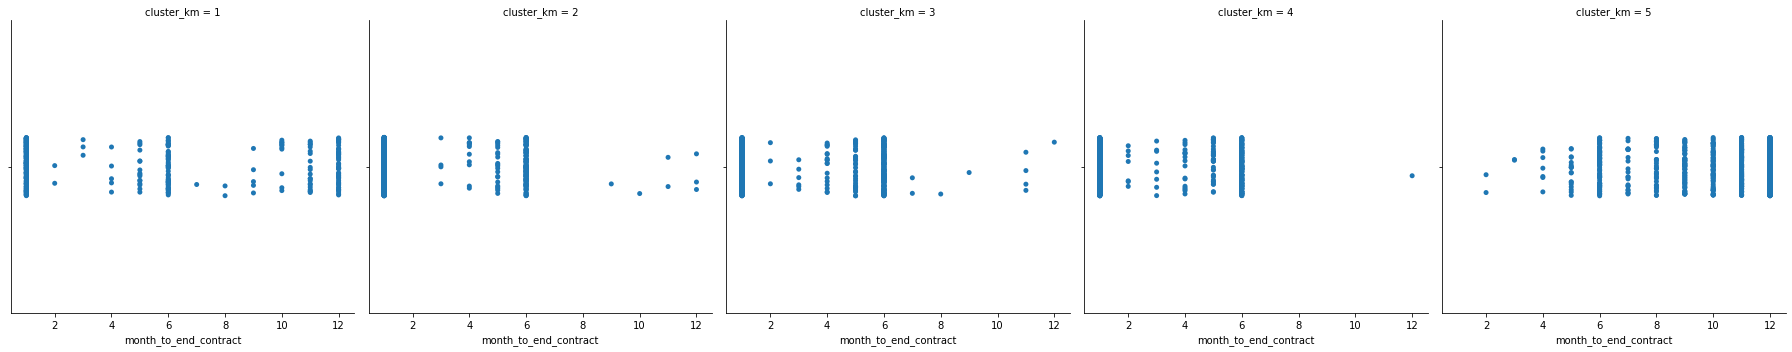

In [36]:
# график распредления количества месяцев до окончания контракта во всех кластерах:

sns.catplot(x='month_to_end_contract',col='cluster_km',data=data)

Как видим, в группах с меньшим уровнем оттока- №1 и №5 - диапазон количества месяцев до окончания контракт довольно широкий, от 1 до 12 месяцев. А вот в группах №2 и №4 диапазон варьируется в основном от 1 до 6 месяцев.

Посчитаем долю оттока для каждого клатера и проверим как они отличаются.


In [37]:
# посчитаем долю оттока:

clusters_churn = data.groupby('cluster_km').agg({'churn':['sum','count']})
clusters_churn.columns = ['churn_n', 'total_n']
clusters_churn['churn_share'] = round(clusters_churn['churn_n']*100/clusters_churn['total_n'],2)
clusters_churn

churn_n  total_n  churn_share
cluster_km                               
1               103      385        26.75
2               587     1066        55.07
3                40      832         4.81
4               309      781        39.56
5                22      936         2.35

Наиболее склонный к оттоку - кластер №2 и №4, с долей клиентов в оттоке 39.5% и 55.07% соответственно.Наименее склонны к оттоку и значит более надёжны -  кластеры № 3 и №5 с долей оттока менее 5%. В кластере под номером 1  - средний уровень оттока, 26.75% от общего числа. 

### Шаг 5. Выводы и рекомендации по работе с клиентами <a id='results'></a>

В ходе текущего проекта, мы построили модель прогнозирования оттока пользователей из сети фитнес-центров, проанализировали значения признаков и визуализировали их распределение с учётом кластеров. Исходя из проделанного анализа, можно сделать следующие выводы:

1. Группа оттока и группа остающихся клиентов отличаются по среднему возрасту, суммарной выручке, и количеству месяцев до окончания срока абонемента. В группе оставшихся клиентов эти показатели выше. 

2. Было выделено 5 кластеров клиентов. Кластеры №3 и №5 наиболее надёжные - уровень оттока в них не превышает 5%. Клстеры №2 и №4 имеют наиболее высокие уровни оттока от 40-55%.

3. Фактор партнерства компании клиента с фитнес-центром является решающим при выборе фитнес-центра и ухода из него для части клиентов, так как предоставляет дополнительные льготы. 

4. Чем длительнее срок действия абонемента и чем дольше времени до его окончания - тем меньше вероятность оттока клиента в ближайшее время. 

5. Высокий уровень активности, который включает посещение групповых занятий, использование дополнительных услуг фитнес-центра и регулярность посещения центра в целом - положительно сказывается на надежности клиента. 

6. В группах с более высоким средним возрастом клиентов наблюдается меньший уровень оттока.

7. Промо-акция "приведи друга" также положительно сказывается на уровне надежности. Скорее всего это связано с выгодой, которую приобретает клиент, получивший абонемент по акции. 

8. Гендерные различия не сильно ощутимы. Но клиенты с гендером, обозначаемым цифрой 1, более склонны к оттоку для большинства кластеров.

9. Чем ближе центр находится к дому или работе клиента, тем меньше вероятность оттока клиента.


### Рекомендации:

1. Компании следует сфокусироваться на маркетинговом продвижении абонементов более длительного срока действия - от 6 месяцев и более. Так как большинство решений об уходе принимаются в первые недели взаимодействия.

2. Стоит увеличь количество групповых занятий с возможностью посещать их в разный временной промежуток, так как это положительно сказывается на лояльности клиентов.

3. Если предлагать клиентам абонемент по специальной цене за 2 месяца до окнчания срока действия текущего абонемента, то можно снизить уровень оттока клиентов.

4. Также, компании стоит отслеживать уровень активности клиентов - посещение фитнес-центра и использование дополнительных услуг (таких как массаж). Снижение данных показателей может сигнализировать о скором уходе клиента из центра. Но прежде чем клиент примет решения, центр может выявить тенденцию и предложить что-то новое (к примеру - персональную тренировку с тренером) для удержания клиента и повышения егоактивности.